In [1]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scipy.signal import argrelextrema,find_peaks
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix,mean_squared_error
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras import backend as K

In [2]:
X_train=np.loadtxt('../../training_data/Xtrain_seg_mask_rv_sm_bal.csv',delimiter=',')
Y_train=np.loadtxt('../../training_data/Ytrain_seg_mask_rv_sm_bal.csv',delimiter=',')
C_train=np.loadtxt('../../training_data/Ctrain_seg_mask_rv_sm_bal.csv',delimiter=',')

print(X_train.shape,Y_train.shape,C_train.shape)

(3624, 4000) (3624, 12000) (3624, 2)


In [3]:
Y_train=Y_train.reshape(len(X_train),4000,3)
print(Y_train.shape)

(3624, 4000, 3)


In [4]:
E_train = np.asarray([min(el) for el in X_train])
print(E_train.shape)


(3624,)


In [5]:
X_train=np.asarray([(row-np.median(row))/(-row[np.argmin(row)]+np.median(row)) for row in X_train])

In [6]:
Xtrain, Xtest, Ytrain, Ytest, Ctrain, Ctest, Etrain, Etest= train_test_split(X_train, Y_train, C_train, E_train, test_size=0.2)
print(Xtrain.shape,Ytrain.shape,Ctrain.shape,Xtest.shape,Ytest.shape,Ctest.shape)

(2899, 4000) (2899, 4000, 3) (2899, 2) (725, 4000) (725, 4000, 3) (725, 2)


<function matplotlib.pyplot.show(close=None, block=None)>

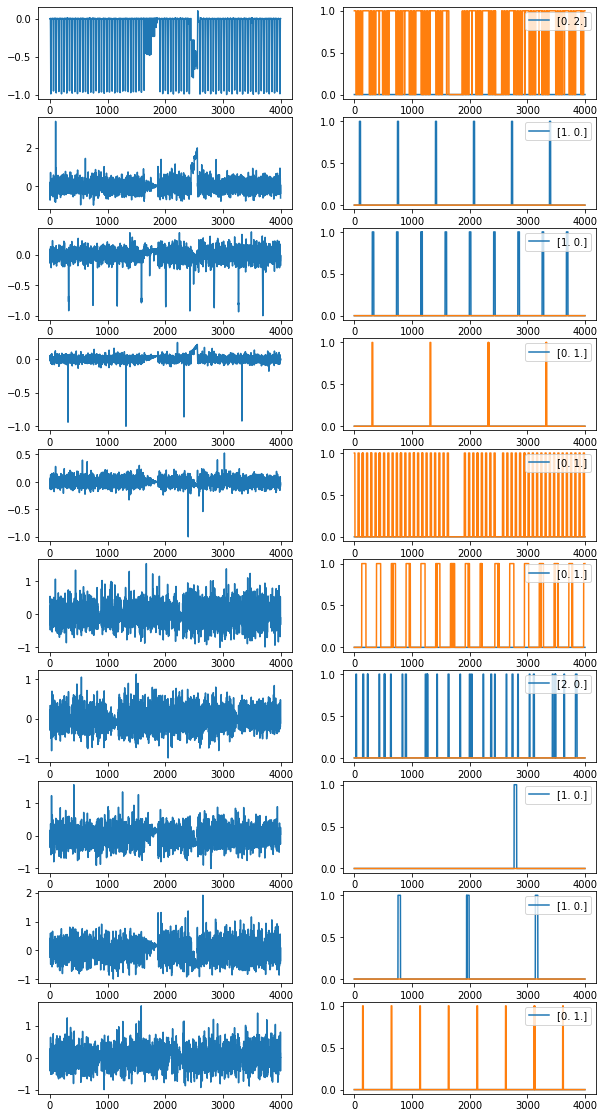

In [7]:
vararr=np.random.randint(0,len(Xtrain),size=10)
fig,ax=plt.subplots(10,2,figsize=(10,20))
for i in range(0,10):
    ax[i][0].plot(Xtrain[vararr[i]])
    #ax[i][1].plot(Ytrain[vararr[i],:,2])
    ax[i][1].plot(Ytrain[vararr[i],:,0],label=Ctrain[vararr[i]])
    ax[i][1].plot(Ytrain[vararr[i],:,1])
    #ax[i][1].set_xlim(2600,3000)
    ax[i][1].legend()
plt.show

In [39]:

def bce_dice_loss(y_true, y_pred):
    loss = keras.losses.binary_crossentropy(y_true, y_pred) + generalized_dice_coeff(y_true, y_pred)
    return loss

def generalized_dice_coeff(y_true, y_pred):
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    w = tf.reduce_sum(y_true,(0,1))
    w= w/tf.linalg.norm(w)
    #w = (1 - w)
    w = 1 / (w  + 0.00001)
    w=tf.cast(w,tf.float32)


    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0, 1))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0, 1))
    denominator = K.sum(denominator)

    gen_dice_coef = numerator / denominator

    return 1 - 2 * gen_dice_coef

In [40]:
IMG_SIZE=4000
#add hidden layers
conv_ip = keras.layers.Input(shape=(IMG_SIZE,),name='Input')
extra_ip = keras.layers.Input(shape=(1,), name='lost_snr')
xi=keras.layers.Reshape((IMG_SIZE, 1), input_shape=(IMG_SIZE,),name='reshape_1')(conv_ip)
#xi=keras.layers.Cropping1D(cropping=(100, 100))(xi)
xi=keras.layers.BatchNormalization()(xi)

x1=keras.layers.SeparableConv1D(32,kernel_size=5,strides=2,activation='tanh',padding='same',name='second_conv32_5')(xi)
c1=keras.layers.SeparableConv1D(32,kernel_size=3,strides=1,activation='tanh',padding='same',name='third_conv32_5')(x1)    #2400,32

x2=keras.layers.BatchNormalization()(c1)
x2=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_1')(x2)   
x2=keras.layers.SeparableConv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='first_conv64_5')(x2)
c2=keras.layers.SeparableConv1D(64,kernel_size=3,strides=1,activation='tanh',padding='same',name='second_conv64_5')(x2) #size 1200,64

x3=keras.layers.BatchNormalization()(c2)
x3=keras.layers.MaxPool1D(3,strides=2 ,data_format='channels_last',padding='same',name='maxpool_2')(x3)   
x3=keras.layers.SeparableConv1D(128,kernel_size=5,strides=1,activation='tanh',padding='same',name='first_conv128_5')(x3)
c3=keras.layers.SeparableConv1D(128,kernel_size=5,strides=1,activation='tanh',padding='same',name='second_conv128_5')(x3) #size 600,128

x4=keras.layers.BatchNormalization()(c3)
x4=keras.layers.MaxPool1D(3,strides=2,data_format='channels_last',padding='same',name='maxpool_3')(x4)    
x4=keras.layers.SeparableConv1D(256,kernel_size=5,strides=1,activation='tanh',padding='same',name='third_conv256_5')(x4)#size 300,256
x4=keras.layers.SeparableConv1D(512,kernel_size=5,strides=1,activation='tanh',padding='same',name='fourth_conv256_5')(x4)#size 300,256

b1=keras.layers.SeparableConv1D(512,kernel_size=3,strides=2,activation='tanh',padding='same',name='bypass')(x4)#size 300,256
b1 = keras.layers.Flatten(name='prethis')(b1)
b1 = keras.layers.Dense(64,activation='relu')(b1)
#b1 = keras.layers.Dense(32,activation='relu')(b1)

b2 = keras.layers.Conv1DTranspose(128, kernel_size=5, activation='relu', padding="same", strides=2, name="dec_conv_tran128_5")(x4)#600,128
b2 = keras.layers.Conv1DTranspose(128, kernel_size=5, activation='relu', padding="same", strides=1, name="dec_conv_tran128_5_2")(b2)#600,128
b2 =keras.layers.BatchNormalization()(b2)

x5 = keras.layers.Concatenate(axis=2)([c3,b2])
x5 = keras.layers.SeparableConv1D(128,kernel_size=3,strides=1,activation='relu',padding='same',name='dec_conv128_5')(x5)
x5 = keras.layers.Conv1DTranspose(64, kernel_size=3, activation='relu', padding="same", strides=2, name="dec_conv_tran64_1")(x5)
x5 = keras.layers.Conv1DTranspose(64, kernel_size=3, activation='relu', padding="same", strides=1, name="dec_conv_tran64_2")(x5)
x5 = keras.layers.BatchNormalization()(x5)  #1200,64

x6 = keras.layers.Concatenate(axis=2)([c2,x5]) 
x6 = keras.layers.SeparableConv1D(64,kernel_size=3,strides=1,activation='relu',padding='same',name='dec_conv64_2')(x6) #1200,64
x6 = keras.layers.Conv1DTranspose(32, kernel_size=3, activation='relu', padding="same", strides=2, name="dec_conv_tran32_5")(x6)
x6 = keras.layers.BatchNormalization()(x6)  #2400,32

x7 = keras.layers.Concatenate(axis=2)([c1,x6]) 
x7 = keras.layers.SeparableConv1D(32,kernel_size=3,strides=1,activation='relu',padding='same',name='dec_conv32_5')(x7) #1200,64
x7 = keras.layers.Conv1DTranspose(32,kernel_size=3,strides=2,activation='relu',padding='same',name='dec_convt32_5')(x7) #1200,64

#b3 = keras.layers.Conv1D(3,kernel_size=3,strides=1,padding='same',name='bef_semiop',activation='relu')(x7)
conv_op = keras.layers.Conv1D(3,kernel_size=3,strides=1,padding='same',name='semiop',activation='softmax')(x7)

#b3 = keras.layers.Flatten()()
b3 = keras.layers.Permute((2,1),name="check")(conv_op)
b3=keras.layers.Reshape((12000,1), name='reshape_2')(b3)
b3 = keras.layers.Cropping1D(cropping=(0,4000))(b3)
b3 = keras.layers.Flatten()(b3)
b4 = keras.layers.Concatenate(name='this')([b1, b3, extra_ip])
b4 = keras.layers.Dense(32,activation='relu')(b4)
b4 = keras.layers.Dense(32,activation='relu')(b4)
b4 = keras.layers.Dense(32,activation='relu')(b4)
b4 = keras.layers.Dense(32,activation='relu')(b4)
cl_op =keras.layers.Dense(2,activation='relu',name='clop')(b4)

keras.backend.clear_session()
#convNN = keras.Model(inputs=[conv_ip,conv_ipl], outputs=conv_op,name='Convolutional_NN')

convNN = keras.Model(inputs=[conv_ip, extra_ip], outputs=[conv_op,cl_op],name='Convolutional_NN')


convNN.summary()
convNN.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00005), 
    loss={'clop': keras.losses.Huber(), 'semiop': bce_dice_loss})

Model: "Convolutional_NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 4000)]       0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 4000, 1)      0           Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4000, 1)      4           reshape_1[0][0]                  
__________________________________________________________________________________________________
second_conv32_5 (SeparableConv1 (None, 2000, 32)     69          batch_normalization[0][0]        
___________________________________________________________________________________

In [41]:
convNN.load_weights('thisonebal.h5')
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history=convNN.fit([np.asarray(Xtrain),Etrain],[np.asarray(Ytrain),np.asarray(Ctrain)], batch_size=32, epochs=15  , verbose=1,  shuffle=True,
     validation_split=0.2)

Epoch 1/15
73/73 [==============================] - 65s 835ms/step - loss: 1.0157 - semiop_loss: 0.7940 - clop_loss: 0.2216 - val_loss: 1.1321 - val_semiop_loss: 0.8258 - val_clop_loss: 0.3064
Epoch 2/15
73/73 [==============================] - 60s 822ms/step - loss: 1.0069 - semiop_loss: 0.7879 - clop_loss: 0.2189 - val_loss: 1.1307 - val_semiop_loss: 0.8246 - val_clop_loss: 0.3060
Epoch 3/15
73/73 [==============================] - 60s 823ms/step - loss: 1.0027 - semiop_loss: 0.7886 - clop_loss: 0.2141 - val_loss: 1.1479 - val_semiop_loss: 0.8345 - val_clop_loss: 0.3133
Epoch 4/15
73/73 [==============================] - 60s 823ms/step - loss: 0.9960 - semiop_loss: 0.7863 - clop_loss: 0.2097 - val_loss: 1.1355 - val_semiop_loss: 0.8241 - val_clop_loss: 0.3114
Epoch 5/15
73/73 [==============================] - 60s 822ms/step - loss: 0.9901 - semiop_loss: 0.7864 - clop_loss: 0.2037 - val_loss: 1.1402 - val_semiop_loss: 0.8240 - val_clop_loss: 0.3163
Epoch 6/15
73/73 [=================

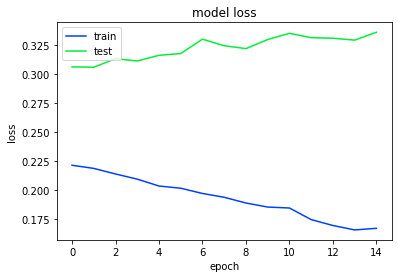

In [42]:
plt.plot(history.history['clop_loss'])
plt.plot(history.history['val_clop_loss'])
#plt.plot(history.history['semiop_loss'])
#plt.plot(history.history['val_semiop_loss'])
plt.title('model loss')  
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('present_segment.png')
plt.show()

In [46]:
pred_op,pred_cl=convNN.predict([np.array(Xtest),Etest])

Text(0.5, 0, 'Phase')

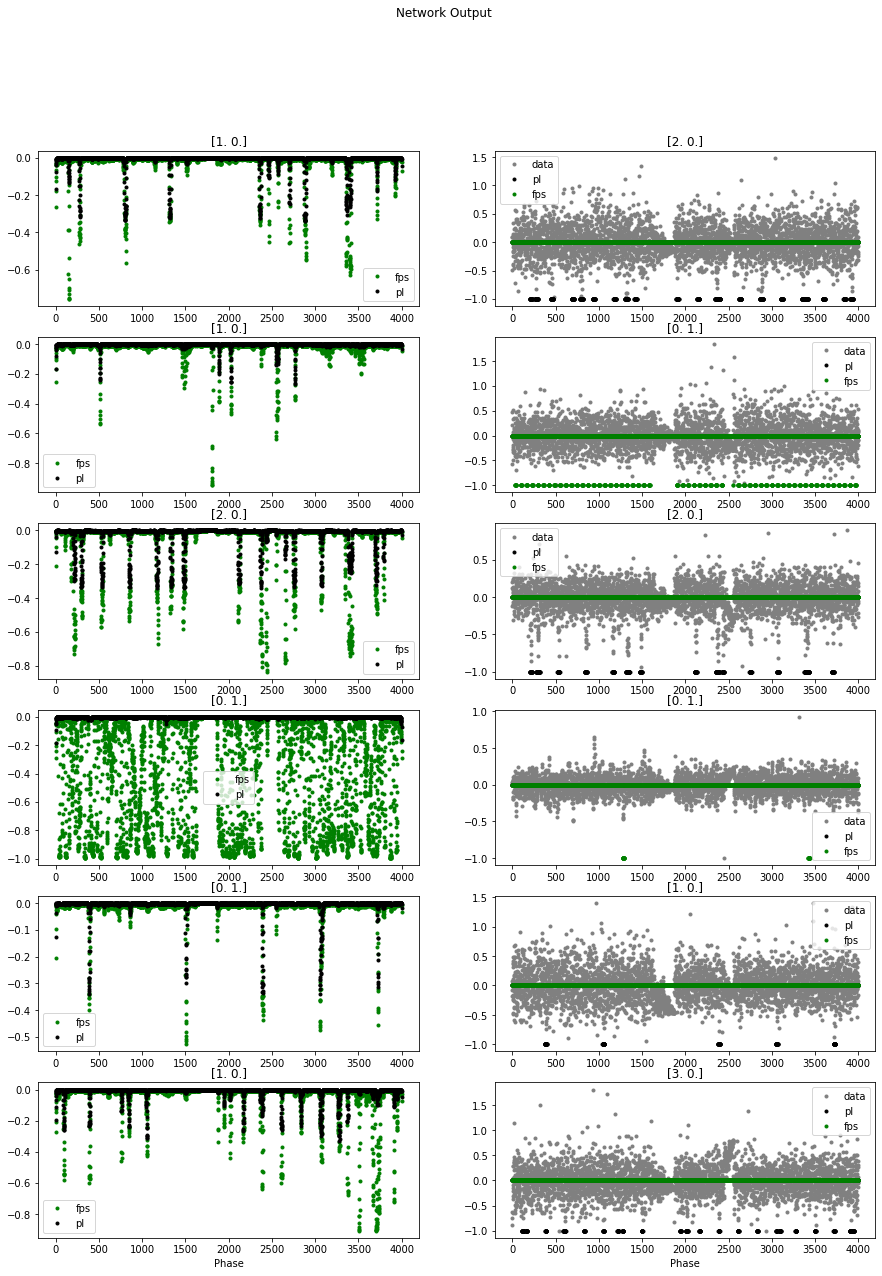

In [48]:

#convNN.load_weights('long_hard_battle_eq.h5')
fig,ax=plt.subplots(6,2,figsize=(15,20))
plt.style.use('seaborn-bright')
plt.suptitle('Network Output')
ar=np.random.randint(len(Xtest),size=10)
#ar=[0,1,2,3,8,7]
ax[0][0].set_title('Generated')
ax[0][1].set_title('Original')
for i in range(0,6):
    #ax[i][0].plot(Xtest[ar[i]],color='gray',ls='None',marker='.',label='data')
    #ax[i][0].plot(-pred_op[ar[i],:,2],color='yellow',ls='None',marker='.',label='bkg')
    ax[i][0].plot(-pred_op[ar[i],:,1],color='green',ls='None',marker='.',label='fps')
    ax[i][0].plot(-pred_op[ar[i],:,0],color='black',ls='None',marker='.',label='pl')
    ax[i][0].set_title(str(np.asarray(np.around(pred_cl[ar[i]]))))

    ax[i][1].plot(Xtest[ar[i]],color='gray',ls='None',marker='.',label='data')
    #ax[i][1].plot(-Ytest[ar[i],:,1],color='yellow',ls='None',marker='.',label='bkg')
    ax[i][1].plot(-Ytest[ar[i],:,0],color='black',ls='None',marker='.',label='pl')
    ax[i][1].plot(-Ytest[ar[i],:,1],color='green',ls='None',marker='.',label='fps')
    ax[i][1].set_title(str(Ctest[ar[i]]))
    
    #ax[i][1].plot(pred_op_mod[ar[i]],color='black',ls='None',marker='.')
    ax[i][0].legend('flux')
    #ax[i][0].set_ylim(-1.05,0.1)
    #ax[i][1].set_ylim(-1.05,0.1)
    ax[i][0].legend()
    ax[i][1].legend()
ax[5][0].set_xlabel('Phase')
ax[5][1].set_xlabel('Phase')

#plt.savefig('present_itsamust')

In [37]:
convNN.save_weights('thisonebal.h5')
#convNN.save('Model_long_hard_battle_av.h5')

In [45]:
comp=[np.around(el) for el in pred_cl]
ntest=[el>0 for el in Ctrain]
npred=[el>0 for el in comp]
#print(ntest,npred)

cm=confusion_matrix(np.asarray(ntest)[:,0],np.asarray(npred)[:,0])
print(cm/cm.sum())

[[0.41428079 0.08830631]
 [0.08727147 0.41014143]]


0.29517683386802673 0.047639827243983746
24 0 31 4
checkalg 0.5870241 0.12832204 0.091543145 0.02301398


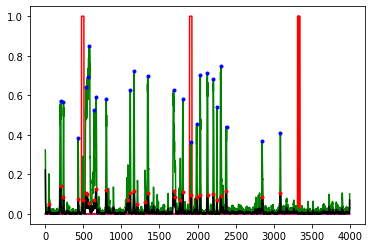

In [17]:
#finding periodicity and all

note=40
x=pred_op[note,:,1]
x2=pred_op[note,:,0]
y=Ytest[note,:,1]
y2=Ytest[note,:,0]
h=(np.median(x)+2*np.std(x))
h2=(np.median(x2)+2*np.std(x2))
print(h,h2)
kernel_size = 22
kernel = np.ones(kernel_size) / kernel_size
#x=np.convolve(x, kernel, mode='same')
#Xtrain = [np.convolve(Xtrain[i], kernel, mode='same') for i in range(IP)]
#Xtest = [np.convolve(Xtest[i], kernel, mode='same') for i in range(TEST)]
peaksf, _ = find_peaks(x, height=h,distance=20)
peaksp, _ = find_peaks(x2, height=h2,distance=20)
peaksft,_ = find_peaks(y, height=0)
peakspt,_ = find_peaks(y2, height=0)
print(len(peaksf),len(peaksft),len(peaksp),len(peakspt))

plwh=np.where(y==1)[0]
fpswh=np.where(y2==1)[0]

print("checkalg",np.mean(x[peaksf]),np.std(x[peaksf]),np.mean(x2[peaksp]),np.std(x2[peaksp]))

plt.plot(y,color='blue')
plt.plot(y2,color='red')
plt.plot(x,color='green')
plt.plot(x2,color='black')

plt.plot(peaksf,x[peaksf],color="blue",marker=".",ls='None')
#plt.plot(peaksft,y[peaksft],color="blue",marker=".",ls='None')
plt.plot(peaksp,x2[peaksp],color="red",marker=".",ls='None')
#plt.plot(peakspt,y2[peakspt],color="red",marker=".",ls='None')


#plt.xlim(0,2000)
plt.show()

In [23]:
#new code to get periodicity... idk if its gonna be worthwile but lets see
#get test data
class_Ytest=[]
for el in Ytrain:
    xpl=el[:,0]
    xfps=el[:,1]
    plp, _ = find_peaks(xpl, height=0)
    pfps, _ = find_peaks(xfps, height=0)
    class_Ytest.append([len(plp),len(pfps)])

class_Ypred=[]
pred_conf=[]
for el in pred_op:
    pl = el[:,0]
    hpl = np.median(pl)+0.1*np.std(pl)
    fps = el[:,1]
    hfps = np.median(fps)+0.1*np.std(fps)
    plp, _ = find_peaks(pl, height=hpl,distance=10)
    fpsp, _ = find_peaks(fps, height=hfps,distance=10) 
    if(len(plp>0)): 
        val1=np.mean(pl[plp])
        std1=np.std(pl[plp])
    else: 
        val1=0
        std1=0
    if(len(fpsp)>0): 
        val2=np.mean(fps[fpsp])
        std2=np.std(fps[fpsp])
    else: 
        val2=0
        std2=0
          
    class_Ypred.append([val1,val2])
    pred_conf.append([std1,std2])
    

print(np.asarray(class_Ypred).shape,np.asarray(class_Ytest).shape)

(2899, 2) (2899, 2)


In [24]:
n_pred=[]
n_test=[]
good_preds=0
for i in range(len(class_Ypred)):
    #planet
    ind=np.argmax(class_Ypred[i])
    if(class_Ypred[i][ind]-0.5*pred_conf[i][ind] > class_Ypred[i][1-ind] + 0.5*pred_conf[i][1-ind]): good_preds+=1
    #else: continue
    n_pred.append(ind)
    if(class_Ytest[i][0]>0 and class_Ytest[i][1]>0): n_test.append(np.argmax(class_Ypred[i]))
    elif(class_Ytest[i][0]>0): n_test.append(0)
    else:  n_test.append(1)

cm=confusion_matrix(np.asarray(n_test),np.asarray(n_pred))
print(good_preds)
print(cm/cm.sum())

1325
[[0.         0.46981718]
 [0.         0.53018282]]
